In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from overlays.no_phase_correction_full_data import no_phase_correction_full_data_overlay
base = no_phase_correction_full_data_overlay('overlays/no_phase_correction_full_data/no_phase_correction_full_data.bit')

base.init_rf_clks()

In [3]:
base.ip_dict

{'radio/axi_dma_avg': {'type': 'xilinx.com:ip:axi_dma:7.1',
  'mem_id': 'S_AXI_LITE',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_S_AXI_LITE_ADDR_WIDTH': '10',
   'C_S_AXI_LITE_DATA_WIDTH': '32',
   'C_DLYTMR_RESOLUTION': '125',
   'C_PRMRY_IS_ACLK_ASYNC': '0',
   'C_ENABLE_MULTI_CHANNEL': '0',
   'C_NUM_MM2S_CHANNELS': '1',
   'C_NUM_S2MM_CHANNELS': '1',
   'C_INCLUDE_SG': '0',
   'C_SG_INCLUDE_STSCNTRL_STRM': '0',
   'C_SG_USE_STSAPP_LENGTH': '0',
   'C_SG_LENGTH_WIDTH': '26',
   'C_M_AXI_SG_ADDR_WIDTH': '64',
   'C_M_AXI_SG_DATA_WIDTH': '32',
   'C_M_AXIS_MM2S_CNTRL_TDATA_WIDTH': '32',
   'C_S_AXIS_S2MM_STS_TDATA_WIDTH': '32',
   'C_MICRO_DMA': '0',
   'C_INCLUDE_MM2S': '0',
   'C_INCLUDE_MM2S_SF': '1',
   'C_MM2S_BURST_SIZE': '16',
   'C_M_AXI_MM2S_ADDR_WIDTH': '64',
   'C_M_AXI_MM2S_DATA_WIDTH': '32',
   'C_M_AXIS_MM2S_TDATA_WIDTH': '32',
   'C_INCLUDE_MM2S_DRE': '0',
   'C_INCLUDE_S2MM': '1',
   'C_INCLUDE_S2MM_SF': '1',
   'C_S2MM_BURST_SIZE': 

In [4]:
# the pl sends 45124 / 2 packets (sampling rate halved via hilbert) of 2 values each which have real and complex part which are 32 bit long each but python doesnt know the difference
# the 4*32 bits are packed into a 128 bit bus
#num_samples = int(22562) # 12 kHz

num_samples2 = int(int(15350000/4.)*4); # 20 kHz, 500 ifgs
num_values2 = int(num_samples2*2)
data_type = np.int16

buffer_orig = allocate(shape=(num_values2,), dtype=data_type)

base.radio.axi_dma_orig.recvchannel.transfer(buffer_orig)

base.radio.passer_config_writer_0.write(base.radio.passer_config_writer_0.register_map.send.address, 1)
base.radio.axi_dma_orig.recvchannel.wait()
base.radio.passer_config_writer_0.write(base.radio.passer_config_writer_0.register_map.send.address, 0)

orig_data = np.copy(np.array(buffer_orig))
buffer_orig.freebuffer()

In [5]:
orig_data_compl = orig_data[::2] + 1j*orig_data[1::2]
#np.savetxt('data_iodine_uncorrected.txt', orig_data_compl)
sample_frequency = 4915.2e6 / 16
time_vec = np.arange(0, num_values2/2/sample_frequency, 1/sample_frequency)

np.save('data/data_reference_uncorrected', orig_data_compl)

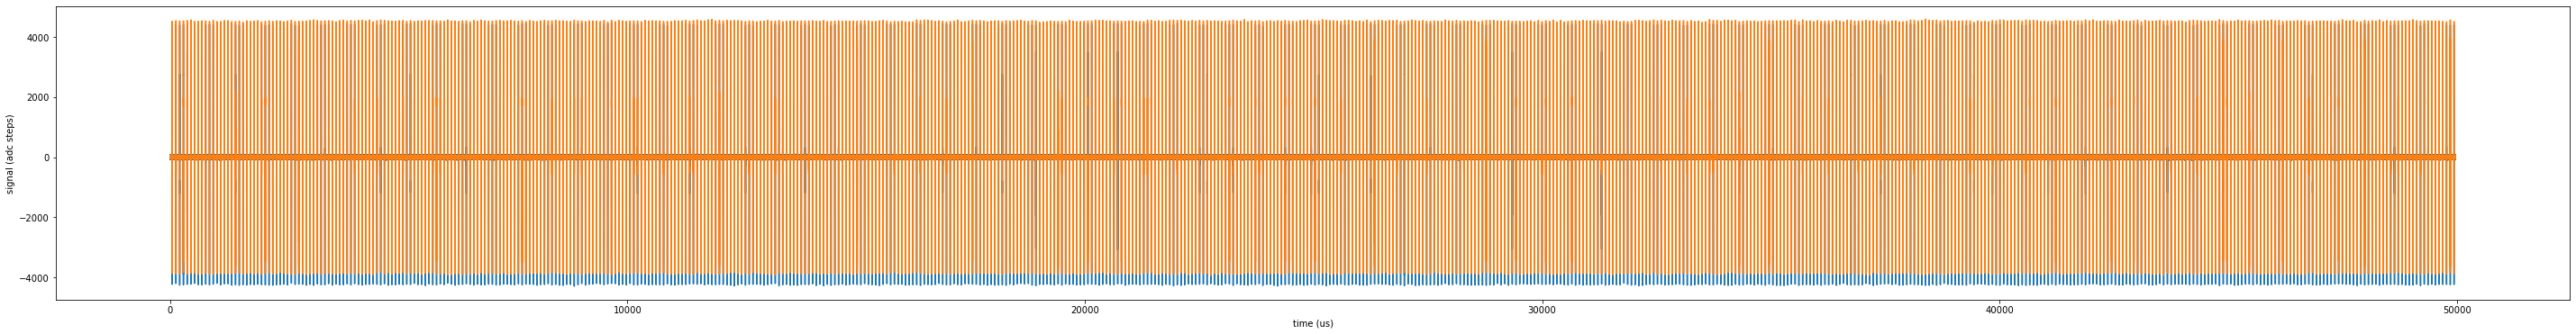

In [6]:
plt.figure(figsize=(50,6))
plt.plot(time_vec*1e6, np.real(orig_data_compl))
plt.plot(time_vec*1e6, np.imag(orig_data_compl))
# plt.xlim([22.2, 23])
plt.xlabel('time (us)')
plt.ylabel('signal (adc steps)')
plt.show()

In [6]:
orig_data_fft = np.fft.fft(orig_data_compl)
freq = np.fft.fftfreq(orig_data_compl.size, d=time_vec[1]-time_vec[0])

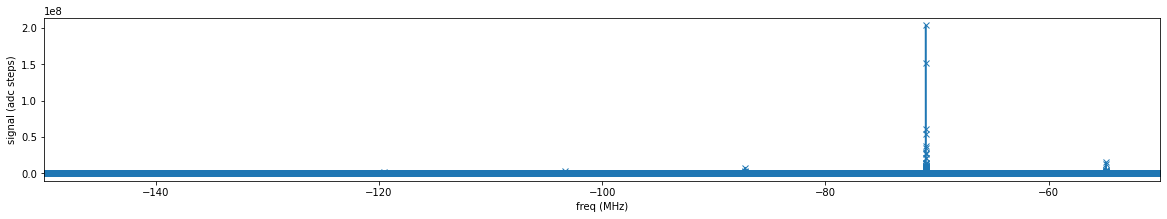

In [7]:
plt.figure(figsize=(20,3))
plt.plot(freq/1e6, np.abs(orig_data_fft), '-x')
plt.xlim([-150, -50])
#plt.xlim([-0.1-80, 0.1-80])
#plt.ylim([0, 5e7])
plt.xlabel('freq (MHz)')
plt.ylabel('signal (adc steps)')
plt.show()